In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
a = '   a a a  '

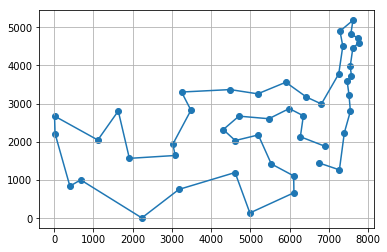

In [126]:
data = []
with open('./att48.tsp') as f:
    for line in f:
        idx, x, y = [int(s) for s in line.strip().split()]
        data.append([x, y])

data = np.array(data)

opt_tour = []
with open('./att48.opt.tour') as f:
    for line in f:
        opt_tour.append(int(line) - 1)

plt.scatter(*data.T)
plt.plot(*data[opt_tour].T)
plt.grid()
plt.show()

dist = np.zeros((48, 48))
for i in range(48):
    for j in range(48):
        dist[i, j] = np.sqrt(((data[i] - data[j])**2).sum())